In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy import special, signal, interpolate

from pypower import CatalogFFTPower, BaseMatrix, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix
from power_spectrum import plot_power, select_region, get_rdd, get_mean_poles, plot_comparison
from mockfactory import Catalog, utils

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = 'plots/'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/'

tracer = 'ELG'
region = 'SGC'
completeness = 'complete_'

In [3]:
window = PowerSpectrumSmoothWindow.load(os.path.join(data_dir, 'windows/window_mock{:d}_{}_{}{}.npy'.format(0, tracer, completeness, region)))

In [4]:
#wmatrix = BaseMatrix.load(os.path.join(data_dir, 'windows/wm_mock0_{}_{}{}.npy'.format(tracer, completeness, region)))
#kinrebin = 10
#wmatrix.slice_x(slicein=slice(0, len(wmatrix.xin[0]) // kinrebin * kinrebin, kinrebin))
#wmatrix.select_x(xinlim=(0.005, 0.35))

## Configuration space

In [5]:
rp_cut = 2.5

In [17]:
def apodization(rp2D, rp_zero, window='tukey', rp_cut=None, **kwargs):
    rp = np.linspace(0, 100, 1000)
    res = np.zeros_like(rp)
    if window == 'tukey':
        kwargs['alpha'] = 1-rp_cut/rp_zero
    if window == 'tophat':
        res[rp < rp_zero] = 1
    else:
        window_function =  getattr(signal.windows, window)
        res[rp < rp_zero] = window_function(M=2*len(rp[rp < rp_zero]), **kwargs)[len(rp[rp < rp_zero]):]
    return interpolate.interp1d(rp, res, bounds_error=False, fill_value=0)(rp2D)

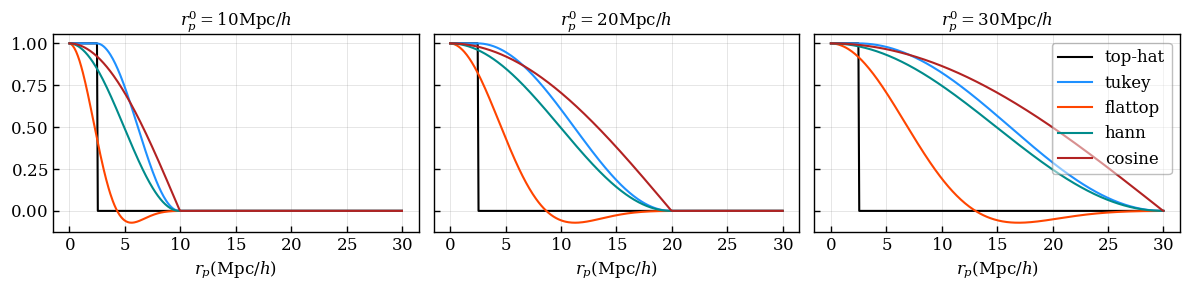

In [18]:
rp = np.linspace(0, 30, 400)

rp_zeros = [10, 20, 30]

fig, axs = plt.subplots(1, len(rp_zeros), figsize=(4*len(rp_zeros), 3), sharey=True)

for i, rp_zero in enumerate(rp_zeros):
    ax = axs[i]
    
    ax.plot(rp, rp < rp_cut, label='top-hat', color='black')

    tukey_corr = apodization(rp, rp_zero, window='tukey', rp_cut=rp_cut)
    flattop_corr = apodization(rp, rp_zero, window='flattop')
    hann_corr = apodization(rp, rp_zero, window='hann')
    cos_corr = apodization(rp, rp_zero, window='cosine')
    ax.plot(rp, tukey_corr, label='tukey' if i==len(rp_zeros)-1 else '', color='C0')
    ax.plot(rp, flattop_corr, label='flattop' if i==len(rp_zeros)-1 else '', color='C1')
    ax.plot(rp, hann_corr, label='hann' if i==len(rp_zeros)-1 else '', color='C2')
    ax.plot(rp, cos_corr, label='cosine' if i==len(rp_zeros)-1 else '', color='C3')
    ax.set_xlabel(r'$r_p (\mathrm{Mpc}/h)$')
    ax.set_title(r'$r_{{p}}^{{0}} = {} \mathrm{{Mpc}}/h$'.format(rp_zero))

ax.legend()
plt.savefig(os.path.join(plots_dir, 'window_function_tests.png'), dpi=200)
plt.show()

## Fourier space

In [19]:
def w2D(kperp, apodized=True, window='tukey', rp=np.linspace(0, 100, 200), rp_zero=10, rp_cut=None):
    if apodized:
        res = [np.trapz(apodization(rp, rp_zero=rp_zero, window=window, rp_cut=rp_cut) * 2 * np.pi * rp * special.jv(0, k * rp), rp) for k in kperp]
    else:
        res = [np.trapz(np.array([1 if r < rp_cut else 0 for r in rp]) * 2 * np.pi * rp * special.jv(0, k * rp), rp) for k in kperp]
    return np.array(res)

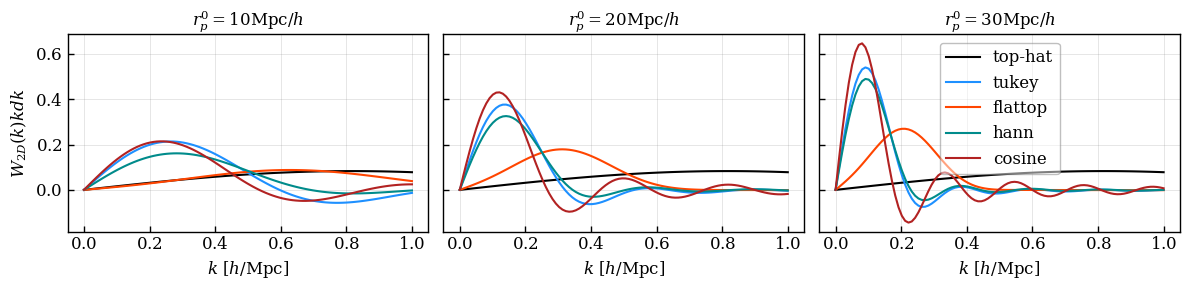

In [20]:
kperp = np.linspace(0, 1., 100)
dk = np.full_like(kperp, 0.0101010)

fig, axs = plt.subplots(1, len(rp_zeros), figsize=(4*len(rp_zeros), 3), sharey=True)

w2D_vals = w2D(kperp, apodized=False, rp_cut=2.5) 
    
for i, rp_zero in enumerate(rp_zeros):
    ax = axs[i]
    ax.plot(kperp, kperp * dk * w2D_vals, label=r'top-hat', color='black', ls='-')
    
    w2D_tukey_vals = w2D(kperp, rp_zero=rp_zero, window='tukey', rp_cut=2.5)
    w2D_flattop_vals = w2D(kperp, rp_zero=rp_zero, window='flattop')
    w2D_hann_vals = w2D(kperp, rp_zero=rp_zero, window='hann')
    w2D_cosine_vals = w2D(kperp, rp_zero=rp_zero, window='cosine')
    ax.plot(kperp, kperp * dk * w2D_tukey_vals, label='tukey' if i==len(rp_zeros)-1 else '', color='C0', ls='-')
    ax.plot(kperp, kperp * dk * w2D_flattop_vals, label='flattop' if i==len(rp_zeros)-1 else '', color='C1', ls='-')
    ax.plot(kperp, kperp * dk * w2D_hann_vals, label='hann' if i==len(rp_zeros)-1 else '', color='C2', ls='-')
    ax.plot(kperp, kperp * dk * w2D_cosine_vals, label='cosine' if i==len(rp_zeros)-1 else '',  color='C3', ls='-')
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_title(r'$r_{{p}}^{{0}} = {} \mathrm{{Mpc}}/h$'.format(rp_zero))

ax.legend()
axs[0].set_ylabel(r'$W_{2D}(k) k dk$')
plt.savefig(os.path.join(plots_dir, 'window_function_fourier_tests.png'), dpi=200)
plt.show()

In [22]:
def apodize(wreal, rp_zero=np.inf, window='tukey', rp_cut=None):
    new = wreal.deepcopy()
    mu = np.linspace(0, 1, 2000)

    for iprojout, projout in enumerate(wreal.projs):
        new.corr[iprojout][...] = 0.
        for iprojin, projin in enumerate(wreal.projs):
            tmp = 2 * (2 * projout.ell + 1.) / 2. * np.trapz((1 - apodization(wreal.sep[:, None] * np.sqrt(1 - mu**2), rp_zero=rp_zero, window=window, rp_cut=rp_cut)) * special.legendre(projout.ell)(mu) * special.legendre(projin.ell)(mu), x=mu)
            #print(projin.ell, projout.ell, np.sum(tmp))
            new.corr[iprojout] += tmp * wreal.corr[iprojin]

    return new

In [23]:
power_fn = 'power_spectra/power_spectrum_mock{:d}_{}_{}{}{}.npy'.format(0, tracer, completeness, region, '_zcut' if completeness else '')
power = CatalogFFTPower.load(data_dir+power_fn).poles

In [24]:
sep = np.geomspace(1e-2, 5e4, 2048)
window_real = window.to_real(sep=sep)
window_real_rp_cut = apodize(window_real, rp_zero=2.5, window='tophat')
sep = np.geomspace(1e-4, 4e3, 1024*16)
wm = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_rp_cut, sep=sep)
wm.save(data_dir+'windows/wm_mock{:d}_{}_{}{}{}.npy'.format(0, tracer, completeness, region, '_rp2.5'))

In [27]:
sep = np.geomspace(1e-4, 4e3, 1024*16)

for rpzero in [5, 10, 20, 30]:
    window_real_apodized_rp_cut = apodize(window_real, rp_cut=rp_cut, rp_zero=rpzero)
    wm = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_apodized_rp_cut, sep=sep)
    wm.save(data_dir+'windows/wm_mock{:d}_{}_{}{}{}.npy'.format(0, tracer, completeness, region, '_rp2.5_apodized_tukey_rpzero{}'.format(rpzero)))

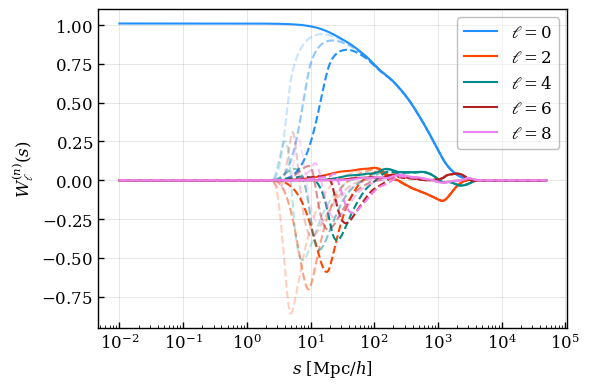

In [25]:
for iproj, proj in enumerate(window.projs):
    if proj.wa_order == 0:
        plt.plot(window_real.sep, window_real(proj=proj), label=r'$\ell = {}$'.format(proj.ell), color='C{}'.format(iproj), alpha=1)
        for rpzero in [5, 10, 20]:
            window_real_apodized_rp_cut = apodize(window_real, rp_cut=rp_cut, rp_zero=rpzero)
            plt.plot(window_real_apodized_rp_cut.sep, window_real_apodized_rp_cut(proj=proj), color='C{}'.format(iproj), alpha=rpzero/20, ls='--')
plt.legend()
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.xscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


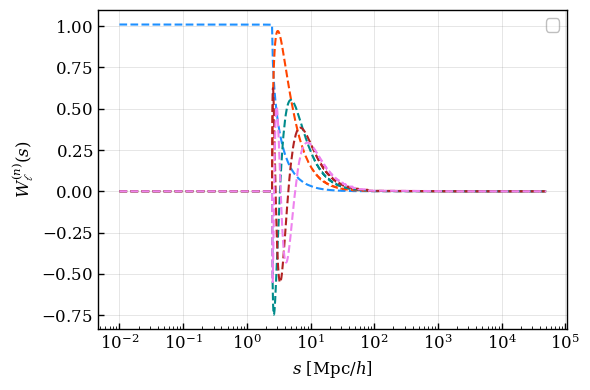

In [17]:
for iproj, proj in enumerate(window.projs):
    if proj.wa_order == 0:
        plt.plot(window_real_apodized_rp_cut.sep, (window_real(proj=proj) - window_real_rp_cut(proj=proj)), color='C{}'.format(iproj), alpha=rpzero/20, ls='--')
plt.legend()
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.xscale('log')
plt.show()